In [ ]:
!git clone https://github.com/ansariminhaj/ulime_github.git

In [1]:
!pip install -r ulime_github/requirements.txt

In [ ]:
!unzip ulime_github/lime_lib_fixed.zip

In [2]:
import torch
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import copy
import skimage.io 
import skimage.segmentation
import copy
import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression
import warnings
import matplotlib.pyplot as plt
from torchsummary import summary
import sys
import torch.optim as optim
import cv2, os, math
from PIL import Image
import requests
import ast
import pandas as pd
import shutil
from itertools import product
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
%matplotlib inline

In [3]:
#Black box model to explain
model = torchvision.models.inception_v3(pretrained=True) #Load pretrained model
model.cuda()

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [4]:
from lime_lib_fixed.lime_org_U.lime import lime_image #(Use a fresh kernel before importing so that cache is empty)
#from lime_org_l2.lime import lime_image #(Use a fresh kernel before importing so that cache is empty)
#from lime_org_cosine.lime import lime_image #(Use a fresh kernel before importing so that cache is empty)

RUN:  1
(10, 16)
(10,)
Label:  0
Weights One:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
none feature_selection
Number of superpixels:  16
(50, 16)
(50,)
Label:  0
Weights One:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
none feature_selection
Number of superpixels:  16
(100, 16)
(100,)
Label:  0
Weights One:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
none feature_selection
Number of superpixels:  16
(200, 16)
(200,)
Label:  0
Weights One:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
none feature_selection
Number of superpixels:  16
(300, 16)
(300,)
Label:  0
Weights One:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
none feature_selection
Number of superpixels:  16
(500, 16)
(500,)
Label:  0
Weights One:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
none feature_selection
Number of superpixels:  16
(700, 16)
(700,)
Label:  0
Weights One:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
none feature_selection
Number of superpixels:  16
(1000, 16)
(1000,)
Label:  0
Weights One:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
none feature_selection
Number of superpixels:  16
(1500, 16)

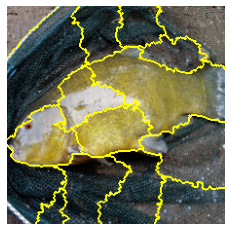

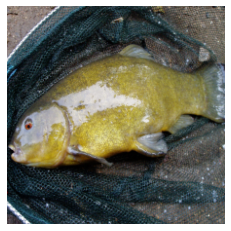

Perturbation:  10 

Mean:  8.248569302174976
Var:  1.5593625835424036
Perturbation:  50 

Mean:  7.915807149696302
Var:  1.0539805478910655
Perturbation:  100 

Mean:  7.393377864015406
Var:  0.5263306740380543
Perturbation:  200 

Mean:  7.083369082863374
Var:  0.2753715351161756
Perturbation:  300 

Mean:  6.562627521577664
Var:  0.6561453380820897
Perturbation:  500 

Mean:  6.134868626231094
Var:  0.20279926077024668
Perturbation:  700 

Mean:  6.065706316171289
Var:  0.365105166652779
Perturbation:  1000 

Mean:  5.796938143940453
Var:  0.24892017170653355
Perturbation:  1500 

Mean:  5.604535924506373
Var:  0.2416096189709167
Perturbation:  2000 

Mean:  5.396508746813961
Var:  0.19099292108959492
Perturbation:  2500 

Mean:  5.411347154806102
Var:  0.23066352181371327
Perturbation:  3000 

Mean:  5.213250038011687
Var:  0.15151033281484946
RUN:  1
(10, 12)
(10,)
Label:  1
Weights One:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
none feature_selection
Number of superpixels:  12
(50, 12)
(50

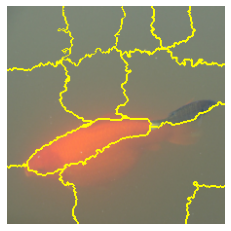

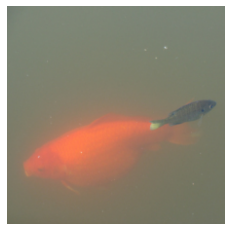

Perturbation:  10 

Mean:  5.204182878300112
Var:  2.2482615209819574
Perturbation:  50 

Mean:  5.694309551924011
Var:  0.44954568752170176
Perturbation:  100 

Mean:  5.124676181306872
Var:  0.7511815743800352
Perturbation:  200 

Mean:  4.523225810461646
Var:  0.25539804001967614
Perturbation:  300 

Mean:  4.50736807223705
Var:  0.31624080676838257
Perturbation:  500 

Mean:  4.246553867540692
Var:  0.14338286074406947
Perturbation:  700 

Mean:  4.286879379268433
Var:  0.1183609894539556
Perturbation:  1000 

Mean:  4.179257282126519
Var:  0.012040748192678533
Perturbation:  1500 

Mean:  4.045600836933378
Var:  0.08607984771661678
Perturbation:  2000 

Mean:  4.034153229795603
Var:  0.029908717442773097
Perturbation:  2500 

Mean:  3.878200950778577
Var:  0.014626058859850914
Perturbation:  3000 

Mean:  3.949578689143822
Var:  0.05382060402458073
RUN:  1
(10, 16)
(10,)
Label:  2
Weights One:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
none feature_selection
Number of superpixels:  16
(50, 

In [ ]:
def heatmap_image(img,c_list,segments):
    num_superpixels = np.unique(segments).shape[0]
    mask = np.zeros(segments.shape)
    for i in range(num_superpixels):
        mask[segments == i] = c_list[i] 
    return mask

def get_image(path):
  with open(os.path.abspath(path), 'rb') as f:
      with Image.open(f) as img:
          return img.convert('RGB') 
        
# resize and take the center part of image to what our model expects
def get_input_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])       
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])    

    return transf

def get_input_tensors(img):
    transf = get_input_transform()
    # unsqeeze converts single image to batch of 1
    return transf(img).unsqueeze(0)

def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()


perturbations_num = [10, 50, 100, 200, 300, 500, 700, 1000, 1500, 2000, 2500, 3000]

explainer = lime_image.LimeImageExplainer(feature_selection='none')

data_labels_folder = "ulime_github/pert_labels" #This folder contains perturbations (data.txt) + corresponding labels (labels.txt) for the first 10 classes. We fix them once and use for all three variants (L2, Cosine and ULIME).

#For generating your own perturbations and labels, follow the steps below: 

#UNCOMMENT these lines in lime_image.py: 

#201 data, labels = self.data_labels(image, fudged_image, segments,
#202                                 classifier_fn, num_samples,
#203                                 batch_size=batch_size,
#204                                 progress_bar=progress_bar)

#COMMENT these lines in lime_image.py:

#206 data = data_fixed
#207 labels = labels_fixed

#UNCOMMENT #[:, label] in line 184 (labels_column = neighborhood_labels#[:, label])

folder_name = "imagenet_ulime1"
os.mkdir(folder_name)
runs = 10

for class_i in range(10):
    os.mkdir(folder_name+"/"+str(class_i))
    for path_dir, dirnames, filenames in os.walk('ulime_github/imagenet_10images/'+str(class_i)):
        coeffs_list=[]
        segments = "" #Store segments to calculate LnO
        num_superpixels = 0 #Store number of superpixels
        image = 0 #Store image

        for file in filenames:
            img_path = path_dir+"/"+file
            img = get_image(img_path)
            plt.imshow(img)
            plt.close()

            image = np.array(pill_transf(img))

            os.mkdir(folder_name+"/"+str(class_i)+"/data")
            os.mkdir(folder_name+"/"+str(class_i)+"/labels")

            for i in range(runs):  
                os.mkdir(folder_name+"/"+str(class_i)+"/data/"+"run_"+str(i))
                os.mkdir(folder_name+"/"+str(class_i)+"/labels/"+"run_"+str(i))  

                print("RUN: ", i+1)

                coeff_list = []

                for p in perturbations_num:
                    num_perturb = p

                    data_fixed = open(data_labels_folder+"/"+str(class_i)+"/data/"+"run_"+str(i)+"/"+str(p)+".txt", "r")
                    data_fixed.readline()
                    data_fixed = np.array(ast.literal_eval(data_fixed.read()))
                    print("Perturbations shape: ", data_fixed.shape)

                    labels_fixed = open(data_labels_folder+"/"+str(class_i)+"/labels/"+"run_"+str(i)+"/"+str(p)+".txt", "r")
                    labels_fixed.readline()
                    labels_fixed = np.array(ast.literal_eval(labels_fixed.read()))
                    print("Labels shape: ", labels_fixed.shape)

                    predictions = []

                    explanation, segments, label, data, labels = explainer.explain_instance(image, 
                                                            batch_predict, data_fixed, labels_fixed,
                                                            class_i, 
                                                            top_labels=1, 
                                                            hide_color=0, 
                                                            num_samples=num_perturb) # number of images that will be sent to classification function

                    fX= open(folder_name+"/"+str(class_i)+"/data/"+"run_"+str(i)+"/"+str(p)+".txt","w+")
                    fX.write("Class: "+str(class_i))
                    fX.write("\n")
                    data_list_all = []

                    for pert_index in range(len(data)):
                      data_list = list(data[pert_index])
                      data_list_all.append(data_list)


                    fX.write(str(data_list_all))
                    fX.write("\n\n")
                    fX.close()

                    fY= open(folder_name+"/"+str(class_i)+"/labels/"+"run_"+str(i)+"/"+str(p)+".txt","w+")
                    fY.write("Class: "+str(class_i))
                    fY.write("\n")

                    # print("Labels Shape: ", labels.shape)
                    # print("Labels: ", labels[:, class_i])

                    labels_list = list(labels)
                    fY.write(str(labels_list))
                    fY.write("\n\n")
                    fY.close()

                    coeff = [None] * (np.unique(segments).shape[0])

                    print("Number of superpixels: ", np.unique(segments).shape[0])
                    num_superpixels = np.unique(segments).shape[0]

                    for exp_tuple in explanation.local_exp[label]:
                      coeff[exp_tuple[0]] = exp_tuple[1]

                    # print("Code Coeff: ", np.array(coeff))
                    # print("Code Coeff Shape: ", np.array(coeff).shape)

                    #Normalize coeff_list
                    coeff_norm = [(float(i)-min(coeff))/(max(coeff)-min(coeff)) for i in coeff]
                    # print("Normalized: ", np.array(coeff_norm))
                    coeff_list.append(coeff_norm)

                coeffs_list.append(coeff_list)

            #coeffs_list contains coefficients of all simpler models trained on all the perturbations_num x 10 RUNS
            # print("Coeff list shape: ", np.array(coeffs_list).shape)
            # print(np.array(coeffs_list))

            plt.imshow(skimage.segmentation.mark_boundaries(image, segments))
            plt.axis('off')
            plt.savefig(folder_name+"/"+str(class_i)+'/seg_image.png', bbox_inches='tight')
            plt.show()
            plt.close()

            plt.imshow(image)
            plt.axis('off')
            plt.savefig(folder_name+"/"+str(class_i)+'/org_image.png', bbox_inches='tight')
            plt.show()
            plt.close()

            fc= open(folder_name+"/"+str(class_i)+"/coeffs_list.txt","w+")
            fc.write("Class: "+str(class_i))
            fc.write("\n")
            fc.write(str(coeffs_list))
            fc.write("\n\n")
            fc.close()
                
            probability_list_run = []
            probability_list_pert = []
            for i in range(runs): #Runs
                probability_list_pert=[]

                for j in range(len(perturbations_num)): #Perturbations
                    probability_list_n=[]

                    for k in range(0, len(coeffs_list[i][j])+1): #Coefficients
                        num_top_features = k
                        if num_top_features == 0:
                            top_features = []
                        else:
                            top_features = np.argsort(coeffs_list[i][j])[-num_top_features:] 


                        mask_exp = np.ones(num_superpixels) 
                        mask_exp[top_features]= False

                        image = np.array(pill_transf(img))
                        fudged_image = image.copy()
                        fudged_image[:] = 0
                        # for x in np.unique(segments):
                        #   fudged_image[segments == x] = (
                        #     np.mean(image[segments == x][:, 0]),
                        #     np.mean(image[segments == x][:, 1]),
                        #     np.mean(image[segments == x][:, 2]))

                        temp = copy.deepcopy(image)
                        zeros = np.where(mask_exp == 0)[0]
                        mask = np.zeros(segments.shape).astype(bool)

                        for z in zeros:
                            mask[segments == z] = True
                        temp[mask] = fudged_image[mask]

                        # plt.imshow(temp)
                        # plt.show()
                        # plt.close()

                        imgs = []
                        imgs.append(temp)

                        preds = batch_predict(np.array(imgs))
                        # print("Prediction Shape: ", preds.shape)
                        # print("Prediction[0] Shape: ", preds[0].shape)
                        # print("Prediction: ", preds)

                        probability_list_n.append(preds[0][class_i])

                    probability_list_pert.append(probability_list_n)

                #probability_list_run structure (Run, Perturbation, LnO (Superpixels + 1))
                probability_list_run.append(probability_list_pert)
                # print(np.array(probability_list_run).shape)
                # print(np.array(probability_list_run))


            f= open(folder_name+"/"+str(class_i)+"/LnO.txt","w+")
            for run in range(runs):
                f.write("RUN: %d\n\n" % run)
                for pert in range(len(perturbations_num)):
                    f.write("PERTURBATION: %d\n" % perturbations_num[pert])
                    f.write(str(probability_list_run[run][pert]))
                    f.write("\n")
            f.close()


            n_list = [n for n in range(num_superpixels+1)]
            _list = []
            _list1 = []

            for pert in range(len(perturbations_num)):
                _list=[]
                for run in range(runs):
                    _list.append(probability_list_run[run][pert])
                _list1.append(_list)
            # print(np.array(_list1).shape)

            os.mkdir(folder_name+"/"+str(class_i)+'/LnO')
            for pert in range(len(perturbations_num)):
                os.mkdir(folder_name+"/"+str(class_i)+'/LnO/'+str(perturbations_num[pert]))
                for run in range(runs):
                    plt.xlabel("n")
                    plt.ylabel("LnO Accuracy")
                    plt.plot(n_list, _list1[pert][run])
                    plt.savefig(folder_name+"/"+str(class_i)+'/LnO/'+str(perturbations_num[pert])+"/run_"+str(run)+'.png', bbox_inches='tight')
                    plt.close()

            for pert in range(len(perturbations_num)):
                for run in range(runs):
                    plt.xlabel("n")
                    plt.ylabel("LnO Accuracy")
                    plt.plot(n_list, _list1[pert][run])
                plt.savefig(folder_name+"/"+str(class_i)+'/LnO/'+str(perturbations_num[pert])+"/all_runs.png", bbox_inches='tight')
                plt.close()


            for run in range(runs):
                os.mkdir(folder_name+"/"+str(class_i)+"/"+str(run))
                os.mkdir(folder_name+"/"+str(class_i)+"/"+str(run)+"/heatmaps")
                for pert in range(len(perturbations_num)):
                    heat_img = heatmap_image(image,coeffs_list[run][pert],segments)
                    plt.imshow(heat_img)
                    plt.axis('off')
                    plt.savefig(folder_name+"/"+str(class_i)+"/"+str(run)+"/heatmaps/"+str(perturbations_num[pert])+".png", bbox_inches='tight')
                    plt.close()

            l1=[]
            l2=[]
            l3=[]

            for pert in range(len(perturbations_num)): #Pick perturbation number
                for n in range(len(probability_list_run[0][0])-1): #Coefficients
                    for run in range(runs): #runs
                        l1.append(coeffs_list[run][pert][n]) #List of kth coeff of all runs for perturbation j 
                    l2.append(l1) #List all coeffs for perturbation pert  
                    l1=[]
                l3.append(l2) #List of all perturbations 
                l2 = []

            # l2 is structured like (per pert) [ [1st coeff for all runs], [2nd coeff for all runs], [3rd coeff for all runs] ... ]
            # l3 is structured like [ [1st pert l2], [2nd pert l2], [3rd pert l2] ... ]

            total_var_l = []
            total_mean_l = []
            f= open(folder_name+"/"+str(class_i)+"/pert_var.txt","w+")
            for pert in range(len(perturbations_num)):
                print("Perturbation: ", perturbations_num[pert],"\n")
                f.write("Perturbation: " + str(perturbations_num[pert]) +"\n")
                total_var = 0
                total_mean = 0
                for n in range(len(l3[pert])): #go through all coefficients
                    total_var += np.var(l3[pert][n])
                    total_mean += np.mean(l3[pert][n])
                    for j in range(n+1, len(l3[pert])):
                        total_var += 2 * np.cov(l3[pert][n], l3[pert][j], ddof=0)[0][1] #Extract covariance value from covariance matrix
                print("Mean: ", total_mean)
                print("Var: ",total_var)
                f.write("Mean: "+str(total_mean)+"\n")
                f.write("Var: "+str(total_var)+"\n")
                total_var_l.append(total_var)
            f.close()

            plt.xlabel("Perturbations")
            plt.ylabel("Variance")
            plt.plot(perturbations_num, total_var_l)
            plt.savefig(folder_name+"/"+str(class_i)+'/pert_var.png', bbox_inches='tight')
    